# 1.Import 

In [1]:
from correct_cells import * 
from dask.array.image import imread as imr

In [2]:
# stardist / tensorflow env variables setup
import os
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import copy
from pathlib import Path
import pandas as pd

import numpy as np
import napari
from napari.utils.notebook_display import nbscreenshot
from tqdm import tqdm
from rich.pretty import pprint

from stardist.models import StarDist2D

from ultrack import track, to_tracks_layer, tracks_to_zarr
from ultrack.imgproc import normalize
from ultrack.imgproc.segmentation import Cellpose
from ultrack.utils import estimate_parameters_from_labels, labels_to_edges
from ultrack.utils.array import array_apply
from ultrack.config import MainConfig

2024-06-03 12:29:14.043265: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 12:29:14.043332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 12:29:14.114391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-03 12:29:14.253841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 12:29:15.650610: W tensorflow/compiler/tf2

# 2. Open napari layers 

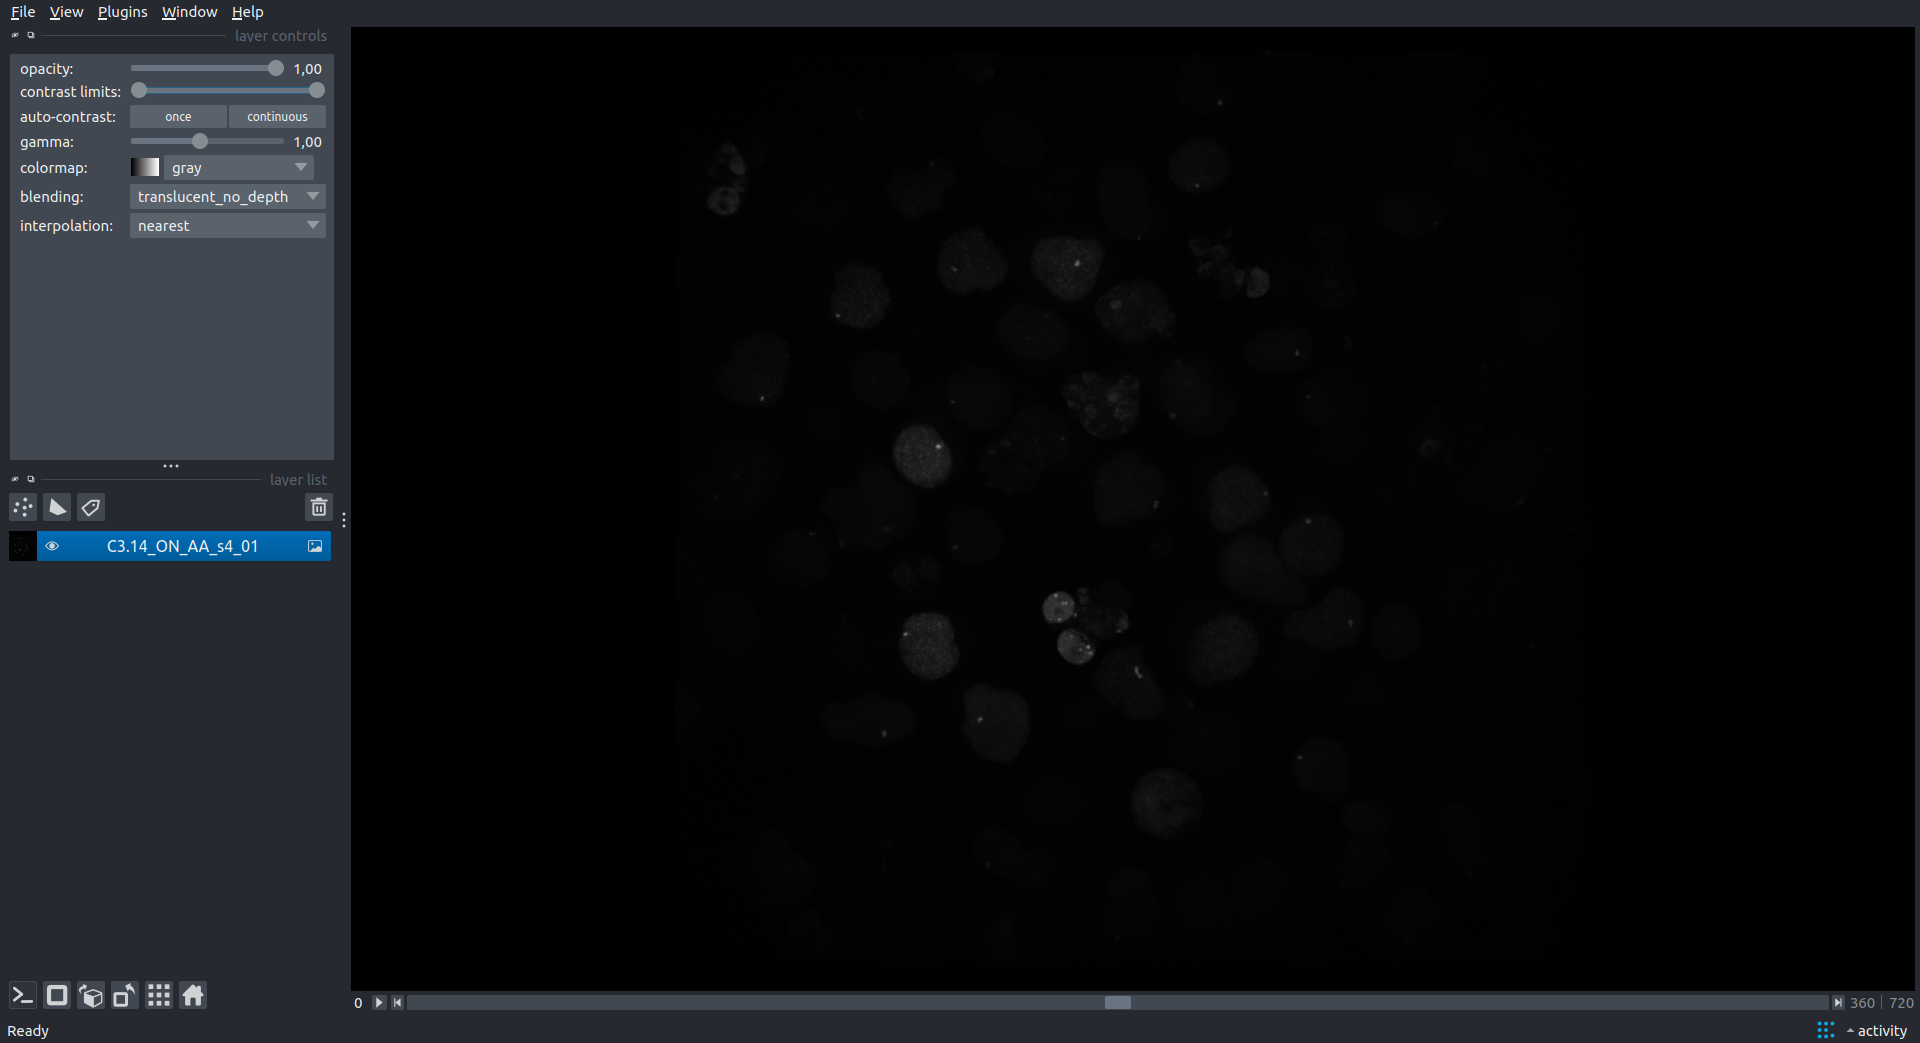

In [3]:
dataset_path = Path("/media/raphael/Genia_ordi/00_C3.14_ON_01_w1SPI-488_s4")

viewer = napari.Viewer()
viewer.window.resize(1800, 1000)
viewer.open(sorted(dataset_path.glob("C3.14_ON_AA_s4_01.tif")), stack=True)

image = viewer.layers[0].data

nbscreenshot(viewer)

In [5]:
cellpose_labels = imr('C3.14_ON_AA_s4_01_cellpose/*.tif')
detection = imr('C3.14_ON_AA_s4_01_detection/*.tif')
edges = imr('C3.14_ON_AA_s4_01_edges/*.tif')

cellpose_labels = cellpose_labels.compute()
detection = detection.compute()
edges = edges.compute()


edges = np.round(edges).astype(np.uint8)
viewer.add_labels(cellpose_labels, name='cellpose')
viewer.add_labels(detection, name='detection')
viewer.add_image(edges,blending="additive", colormap="magma")

<Image layer 'edges' at 0x7efdf8963460>

In [4]:
cellpose_labels = imr('C3.14_ON_AA_s4_01_cellpose/*.tif')
detection = imr('C3.14_ON_AA_s4_01_detection/*.tif')
edges = imr('C3.14_ON_AA_s4_01_edges/*.tif')

#cellpose_labels = cellpose_labels.compute()
#detection = detection.compute()
edges = edges.compute()


#edges = np.round(edges).astype(np.uint8)
#viewer.add_labels(cellpose_labels, name='cellpose')
#viewer.add_labels(detection, name='detection')
#viewer.add_image(edges,blending="additive", colormap="magma")

# 3. Tracking 

In [5]:
config = MainConfig()
pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=100,
│   │   max_area=1000000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7faff790dbd0>,
│   │   n_workers=1
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=1,
│   │   max_neighbors=5,
│   │   max_distance=15.0,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-0.001,
│   │   disappear_weight=-0.001,
│   │   division_weight=-0.001,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=0.001,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='power',
│   │   power=4,
│   │   bias=-0.0
│   )
)

Estimating params.: 100%|█████████████████████| 721/721 [00:28<00:00, 25.29it/s]


<Axes: title={'center': 'Area histogram'}, ylabel='Frequency'>

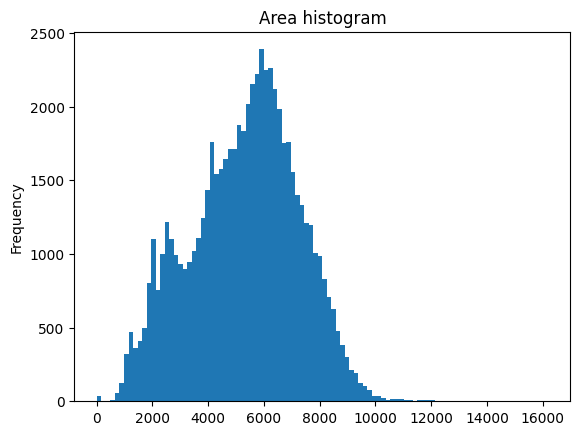

In [6]:
params_df = estimate_parameters_from_labels(cellpose_labels, is_timelapse=True)
params_df["area"].plot(kind="hist", bins=100, title="Area histogram")

In [7]:
weight = 25
workers = 8*2

In [8]:
config.segmentation_config.min_area = 500
config.segmentation_config.max_area = 11000
config.segmentation_config.n_workers = workers

In [9]:
config.linking_config.max_distance = 60 #maximum spatial distance between cells
config.linking_config.n_workers = workers #Number of worker threads
#config.linking_config.distance_weight = 0.01


config.tracking_config.appear_weight = -weight #appear_weight: Penalization weight for appearing cell, should be negative
config.tracking_config.disappear_weight = -weight #disappear_weight: Penalization for disappearing cell, should be negative 
config.tracking_config.division_weight = -weight/1.5 #division_weight: Penalization for dividing cell, should be negative
config.tracking_config.power = 125
config.tracking_config.bias = -0.01
config.tracking_config.solution_gap = 90 #solver solution gap
config.tracking_config.link_function = 'identity'


pprint(config)

MainConfig(
│   data_config=DataConfig(working_dir=PosixPath('.'), database='sqlite', address=None, n_workers=1),
│   segmentation_config=SegmentationConfig(
│   │   threshold=0.5,
│   │   min_area=500,
│   │   max_area=11000,
│   │   min_frontier=0.0,
│   │   anisotropy_penalization=0.0,
│   │   max_noise=0.0,
│   │   ws_hierarchy=<function watershed_hierarchy_by_area at 0x7faff790dbd0>,
│   │   n_workers=16
│   ),
│   linking_config=LinkingConfig(
│   │   n_workers=16,
│   │   max_neighbors=5,
│   │   max_distance=60,
│   │   distance_weight=0.0,
│   │   z_score_threshold=5.0
│   ),
│   tracking_config=TrackingConfig(
│   │   appear_weight=-25,
│   │   disappear_weight=-25,
│   │   division_weight=-16.666666666666668,
│   │   dismiss_weight_guess=None,
│   │   include_weight_guess=None,
│   │   window_size=None,
│   │   overlap_size=1,
│   │   solution_gap=90,
│   │   time_limit=36000,
│   │   method=0,
│   │   n_threads=-1,
│   │   link_function='identity',
│   │   power=125,
│   │   bias=-0.01
│   )
)

In [ ]:
track(
    detection=detection,
    edges=edges,
    config=config,
    overwrite=True,
)

Adding nodes to database:   0%|                         | 0/721 [00:00<?, ?it/s]

In [ ]:
tracks_df, graph = to_tracks_layer(config)
labels = tracks_to_zarr(config, tracks_df)

In [ ]:
viewer.add_tracks(tracks_df[["track_id", "t", "y", "x"]].values, graph=graph)
viewer.add_labels(labels)

#viewer.layers["cellpose"].visible = False
#viewer.layers["edges"].visible = False
#viewer.layers["detection"].visible = False
nbscreenshot(viewer)

In [ ]:
percentage,cells_res = get_cells_numbers_on_all_frames(labels)

In [ ]:
cells_res

# 4. Save labels 

In [ ]:
savepath = "/scratch/rtranchot/work/00_C3.14_ON_01_w1SPI-488_s4"
save_zarr_images(labels,savepath,"C3.14_ON_01_w1SPI-488_s","4","labels")